# [Open in Google Colab](https://colab.research.google.com/github/Jechen00/yolov1-pytorch/blob/main/yolov1_training.ipynb)

# Packages and Dependencies


In [1]:
from IPython.display import clear_output
import torch
import os, sys
import random

# Importing torchmetrics
try:
  import torchmetrics
except:
  print('\033[1m[ALERT]\033[0m torchmetrics not found. Installing with pip...')
  !pip install torchmetrics


# Importing github modules
try:
  from src import constants, data_setup, models, evaluate, loss, engine
  from src.utils import misc, plot

except:
  print('\033[1m[ALERT]\033[0m Modules not found. Cloning from GitHub...')
  !git clone https://github.com/Jechen00/yolov1-pytorch.git

  # print('\033[1m[ALERT]\033[0m Installing package requirements...')
  # !pip install -r ./yolov1-pytorch/requirements.txt

  sys.path.append(os.path.abspath('./yolov1-pytorch'))
  from src import constants, data_setup, models, evaluate, loss, engine
  from src.utils import misc, plot

clear_output(wait = True) # Clear the cluttered output after setup
print(f'\033[1mDevice:\033[0m {constants.DEVICE}')
print(f'\033[1mCPU count:\033[0m {os.cpu_count()}')

misc.set_seed(6) # Set seed for reproducibility

Device: cuda
CPU count: 12


# YOLOv1 Model

In [2]:
# Configs
S, B, C = 7, 2, 20
DROP_PROB = 0.5
INCLUDE_BN = True

# Creating model
backbone = models.build_resnet50_backbone()
yolov1 = models.YOLOv1(backbone = backbone,
                       S = S, B = B, C = C,
                       drop_prob = DROP_PROB,
                       include_bn = INCLUDE_BN)
yolov1 = yolov1.to(constants.DEVICE)
# yolov1 = torch.compile(yolov1) # Note: The current saved model in ./saved_models wasn't trained with compile

# Dataloaders

In [24]:
# Configs
ACCUM_BATCH_SIZE = 64 # Used in YOLOv1 paper
BATCH_SIZE = 32 # If lower batch_size needed to prevent OOM
NUM_WORKERS = 10

# Creating dataloaders
train_loader, val_loader = data_setup.get_dataloaders(
    root = './data',
    S = yolov1.S, B = yolov1.B,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
)

# Loss Function, Optimizer, Scheduler

In [4]:
# Loss Function Configs
LAMBDA_COORD = 5
LAMBDA_NOOBJ = 0.5

# Optimizer Configs
LEARNING_RATE = 2.5e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

# LR Scheduler Configs
GAMMA = 0.2
MILESTONES = [75, 105]
PRE_WARMUP_LRS = [1e-3]
WARMUP_EPOCHS = 0

# Make loss_function, optimizer, scheduler
loss_fn = loss.YOLOv1Loss(S = yolov1.S, B = yolov1.B, C = yolov1.C,
                          lambda_coord = LAMBDA_COORD,
                          lambda_noobj = LAMBDA_NOOBJ,
                          reduction = 'mean')

optimizer = torch.optim.SGD(params = yolov1.parameters(),
                            lr = LEARNING_RATE,
                            momentum = MOMENTUM,
                            weight_decay = WEIGHT_DECAY)

scheduler = engine.WarmupMultiStepLR(optimizer,
                                     pre_warmup_lrs = PRE_WARMUP_LRS,
                                     milestones = MILESTONES,
                                     warmup_epochs = WARMUP_EPOCHS,
                                     gamma = GAMMA)

# Training-Eval and Checkpoint Configurations

In [5]:
# Training/Evaluation Configs
te_cfgs = engine.TrainEvalConfigs(
    num_epochs = 150,
    accum_steps = int(ACCUM_BATCH_SIZE / BATCH_SIZE), # Simulates batch size of 64
    eval_intervals = 5,
    obj_threshold = 0.2,
    nms_threshold = 0.5,
    map_thresholds = [0.5]
)

ckpt_cfgs = engine.CheckpointConfigs(
    save_dir = './saved_checkpoints',
    checkpoint_name = 'yolov1_checkpoint.pth',
    ignore_exists = False,
    resume = False, # Training from scratch
    resume_path = None
)

# Run Training
Note: This cell seems to crash to first time it is ran.
      After restarting the session and rerunning, everything works fine.

In [6]:
# Note: The current displayed outputs are from a resumed training session (trained up to epoch 150).
      # However, this code trains from scratch with `resume = False`

# Note: This was trained on a Google Colab A100 GPU
train_losses, val_losses, eval_history = engine.train(model = yolov1,
                                                      train_loader = train_loader,
                                                      val_loader = val_loader,
                                                      loss_fn = loss_fn,
                                                      optimizer = optimizer,
                                                      scheduler = scheduler,
                                                      te_cfgs = te_cfgs,
                                                      ckpt_cfgs = ckpt_cfgs,
                                                      device = constants.DEVICE)

[NOTE] Checkpoints will be saved to ./saved_checkpoints/yolov1_checkpoint.pth.
[NOTE] Successfully loaded checkpoint at ./drive/MyDrive/yolov1-pytorch/saved_checkpoints/yolov1_checkpoint_135.pth. Resuming training from epoch 135.

[EPOCH 135 | Train Loss  ] Total: 0.8411  | Class: 0.1701  | Local: 0.1034  | ObjConf: 0.0961  | NoObjConf: 0.1157  | 
[EPOCH 135 | Val Loss    ] Total: 1.8253  | Class: 0.4107  | Local: 0.2338  | ObjConf: 0.1384  | NoObjConf: 0.2144  | 
[EPOCH 135 | Val Metrics ] mAP: 0.5612
[EPOCH 135 | Time        ] Train: 103.33 sec  | Val: 32.20 sec  

[EPOCH 136 | Train Loss  ] Total: 0.8499  | Class: 0.1716  | Local: 0.1043  | ObjConf: 0.0970  | NoObjConf: 0.1198  | 
[EPOCH 136 | Val Loss    ] Total: 1.8290  | Class: 0.4125  | Local: 0.2333  | ObjConf: 0.1390  | NoObjConf: 0.2218  | 
[EPOCH 136 | Time        ] Train: 100.29 sec  | Val: 14.06 sec  

[EPOCH 137 | Train Loss  ] Total: 0.8381  | Class: 0.1714  | Local: 0.1018  | ObjConf: 0.0977  | NoObjConf: 0.1200  | 
[EP

# Plotting Result

Final mAP: 0.5690679550170898


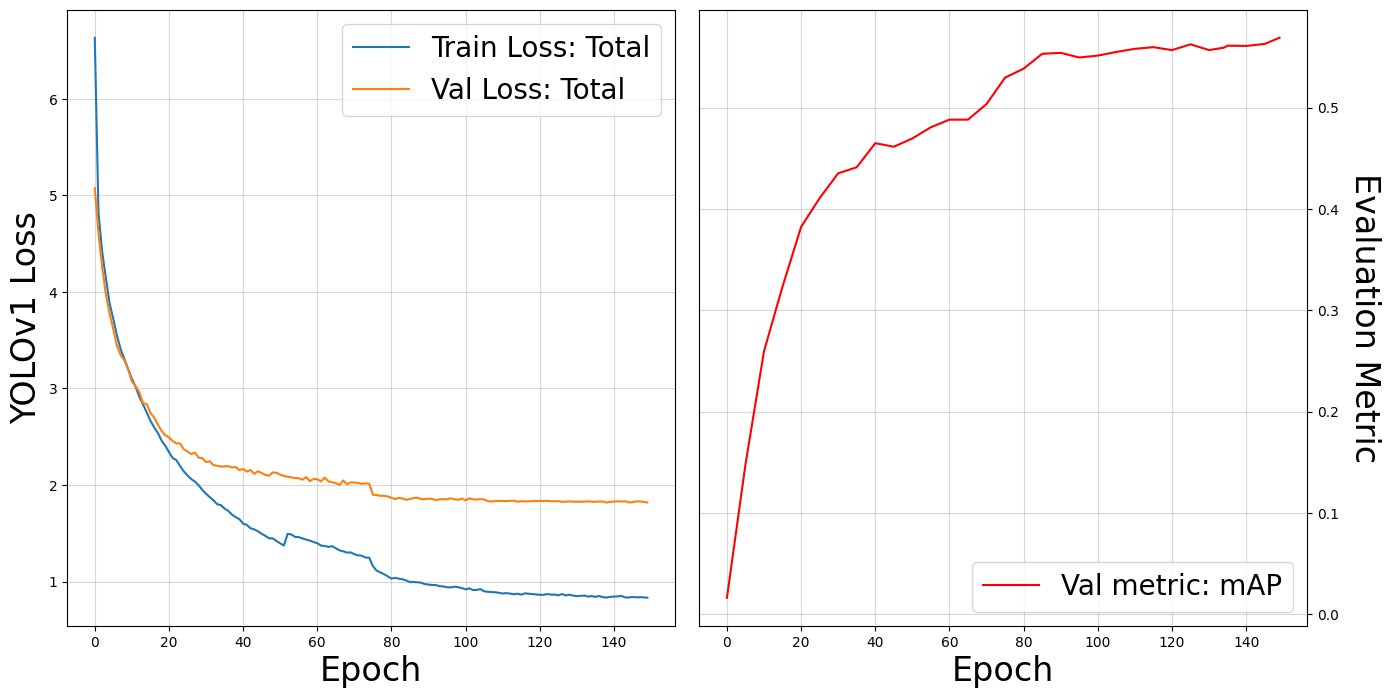

In [21]:
# Load checkpoint
checkpoint = torch.load(ckpt_cfgs.save_path, map_location = constants.DEVICE)

# Create checkpoint model
ckpt_backbone = models.build_resnet50_backbone()
ckpt_yolov1 = models.YOLOv1(backbone = ckpt_backbone,
                       S = S, B = B, C = C,
                       drop_prob = DROP_PROB,
                       include_bn = INCLUDE_BN)
ckpt_yolov1 = ckpt_yolov1.to(constants.DEVICE)
ckpt_yolov1.load_state_dict(checkpoint['model'])
# ckpt_yolov1 = torch.compile(ckpt_yolov1)

# Plot losses and eval metrics from training
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

eval_history = checkpoint['eval_history']
map_scores = [eval_history[key]['map'] for key in eval_history]
print(f'Final mAP: {map_scores[-1]}')

plot.plot_results(train_losses, val_losses, eval_history,
                  loss_key = 'total', eval_key = 'map')

# Mean Average Precision

In [26]:
# Compute mAP and mAR metrics on validation dataset
  # This will change a lot depending on `obj_threshold`, `nms_threshold`, and `map_thresholds`
  # I don't think the original paper reported what values they used for these
evaluate.calc_dataset_map(model = ckpt_yolov1,
                          dataloader = val_loader,
                          obj_threshold = 0.2,
                          nms_threshold = 0.5,
                          map_thresholds = [0.5],
                          device = constants.DEVICE)

{'map': tensor(0.5691),
 'map_50': tensor(0.5691),
 'map_75': tensor(-1.),
 'map_small': tensor(0.5691),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.4806),
 'mar_10': tensor(0.6122),
 'mar_100': tensor(0.6130),
 'mar_small': tensor(0.6130),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor([0.5415, 0.6040, 0.8189, 0.5979, 0.7866, 0.7405, 0.5848, 0.6937, 0.6669,
         0.3605, 0.6589, 0.5980, 0.6914, 0.7580, 0.2181, 0.2840, 0.4544, 0.2537,
         0.4769, 0.5927]),
 'mar_100_per_class': tensor([0.6023, 0.6384, 0.8482, 0.6569, 0.8298, 0.7613, 0.6209, 0.7088, 0.6901,
         0.4176, 0.6802, 0.6213, 0.7213, 0.7815, 0.2825, 0.3693, 0.5192, 0.3154,
         0.5745, 0.6211]),
 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19], dtype=torch.int32)}

# Predictions

In [28]:
# Prediction Configs
OBJ_THRESHOLD = 0.2
NMS_THRESHOLD = 0.4

IMG_RESIZE = (448, 448)

SHOW_SCORES = True
SHOW_PROBS = False

NUM_SAMPLES = 3

# Plotting Predictions
val_dataset = val_loader.dataset
transforms = data_setup.get_transforms(train = False)
sample_idxs = random.sample(range(len(val_dataset)), NUM_SAMPLES)

for i in sample_idxs:
    img = val_dataset.get_img(i)

    fig = plot.draw_preds_yolov1(ckpt_yolov1, img, transforms,
                                 OBJ_THRESHOLD, NMS_THRESHOLD,
                                 IMG_RESIZE,
                                 SHOW_SCORES, SHOW_PROBS,
                                 device = constants.DEVICE)
    display(fig)

Output hidden; open in https://colab.research.google.com to view.

# Downloading Checkpoint

In [1]:
# from google.colab import files

# # Replace with your file path
# files.download('./saved_checkpoints/yolov1_checkpoint.pth')